In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import os
import time
import numpy as np
import sys
import cPickle as pickle
from   random import *
import scipy.stats
import matplotlib.pyplot as plt
sys.path.insert(1,'./code')
from visualize import plot_raw_data, get_population_data, plot_results
from EM import TransformToProb, RunEM
import pyparticleest.models.nlg as nlg
import pyparticleest.simulator as simulator
import pyparticleest.utils.kalman as kalman
from scipy.stats import bernoulli

Falling back to pure python implementaton, expect horrible performance


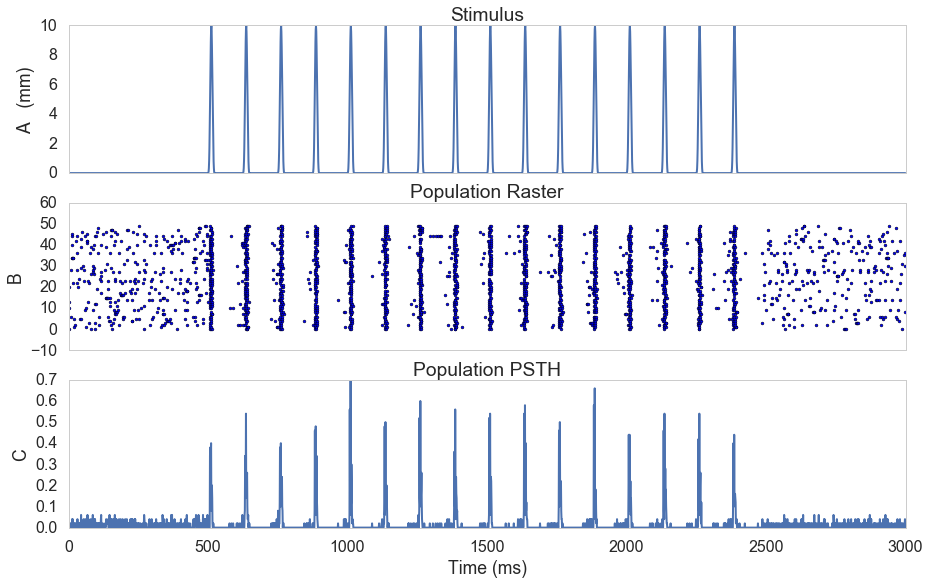

In [3]:
# Get a set of whisker data and plot the raster plot
path = '/Users/macbookpro/Desktop/Gwungwun/Data/'
resp_values_1711 = get_population_data(17,1,1, path = path)
#resp_values_1711 = pickle.load(open('/Users/macbookpro/Documents/ss_model_mixture/resp_values_1711.p','rb'))
plot_raw_data(17,1,1,0,figsize=[15,9],path=path)

resp_values_1711 is the loaded whisker data and it's of shape (50,3000), you need to sum it up across axis 0 and then use the data.

In [4]:
print resp_values_1711.shape
Y = np.sum(resp_values_1711, axis = 0)
print Y.shape

(50, 3000)
(3000,)


initial sigma2e is 0.25

Converged after 77 iterations
sigma2e is  0.505904874894
runtime: 28.7061910629 seconds


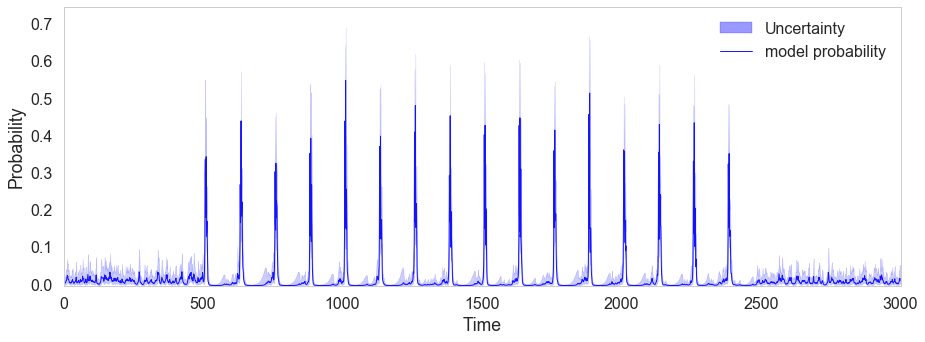

In [23]:
# Run EM on the data set and show results
pmode_1711, p_1711, pll_1711, pul_1711, sigma2e_1711 = RunEM(resp_values_1711)
plot_results(resp_values_1711, pmode_1711, p_1711, pll_1711, pul_1711, ylim=[0,0.75])

In [26]:
print sigma2e_1711

0.505904874894


Create a list of sigmas around `sigma2e_1711`.

In [27]:
sigma_ls = np.arange(sigma2e_1711-0.2, sigma2e_1711+0.2,0.01)
print len(sigma_ls)

41


Now evaluate likelikehood using the list of sigmas. Feel free to play around with the list of sigmas and the step sizes.

In [5]:
class StdNonLin(nlg.NonlinearGaussianInitialGaussian):
    # x_{k+1} = x_k  + v_k = f(x_k) + v_k,
    # y_k = 0 + e_k = g(x_k) + e_k,
    # x(0) ~ N(0,P0), v_k ~ N(0,Q), e_k ~ Binom(50,\exp(x_{k})/(1+\exp(x_{k})))

    def __init__(self, P0, Q):
    # Set covariances in the constructor since they
    # are constant
        super(StdNonLin, self).__init__(Px0=P0, Q=Q)

    def calc_g(self, particles, t):
    # Calculate value of g(\xi_t,t)
        return np.zeros([len(particles),1])
    
    def calc_f(self, particles, u, t):
    # Calculate value of f(xi_t,t)
        return particles
    
    def measure(self, particles, y, t):
        """
        Return the log-pdf value of the measurement
        Args:
         - particles  (array-like): Model specific representation
           of all particles, with first dimension = N (number of particles)
         - y (array-like):  measurement
         - t (float): time-stamp
        Returns:
         (array-like) with first dimension = N, logp(y|x^i)
        """
        N = len(particles)
        lpy = np.empty(N)
        g = self.calc_g(particles=particles, t=t)
 

        if (g is None):
            g = np.repeat(self.g.reshape((1, -1, 1)), N, 0)
        else:
            g = g.reshape((N, -1, 1))
        yrep = np.repeat(np.asarray(y).reshape((1, -1, 1)), N, 0)
        diff = yrep - g
        
        lpy = np.empty(N)
        for i in xrange(N):
            #lpy[i] = bernoulli.logpmf(diff[i],np.exp(particles[i])/(1.0 + np.exp(particles[i])))
            lpy[i] =scipy.stats.binom.logpmf(diff[i],50,np.exp(particles[i])/(1.0 + np.exp(particles[i])),loc=0)
        return lpy

In [6]:
class unnormalizedSimulator(simulator.Simulator):
    def get_filtered_estimates(self):
        """
        Returns type (est, w) (must first have called 'simulate')
         - est: (T, N, D) array containing all particles
         - w: (T,D) array containing all particle weights
        T is the length of the dataset, N is the number of particles and
        D is the dimension of each particle
        """

        T = len(self.pt.traj)
        N = self.pt.traj[0].pa.part.shape[0]
        D = self.pt.traj[0].pa.part.shape[1]

        est = np.empty((T, N, D))

        wtmp = np.empty((T, N))

        for t in xrange(T):
            wtmp[t] = np.exp(self.pt.traj[t].pa.w)
            est[t] = self.pt.traj[t].pa.part

        return (est, wtmp)


In [24]:
T = 3000
P0 = 0.5 * np.eye(1)
#Q = 0.4 * np.eye(1)

# Forward particles
N = 100
# Backward trajectories
M = 1

In [25]:
model = StdNonLin(P0, Q)

sim = unnormalizedSimulator(model, u=None, y=Y)
sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)

910

In [26]:
(est_filt, w_filt) = sim.get_filtered_estimates()
w_filt.shape

(3000, 100)

In [27]:
#likelihood=np.prod(np.sum(w_filt, axis = 1)/N)
likelihood=np.prod(np.sum(w_filt, axis = 1)/(N/2))
print likelihood

1.19678261909e-63


In [59]:
%%time
likelihood=np.empty(41)

for i in range(41):
    Q=0.4 * np.eye(1)+0.01*i*np.eye(1)
    model = StdNonLin(P0, Q)
    sim = unnormalizedSimulator(model, u=None, y=Y)
    sim.simulate(N, M, filter='PF', smoother='full', meas_first=True)
    (est_filt, w_filt) = sim.get_filtered_estimates()
    likelihood[i]=np.prod(np.sum(w_filt, axis = 1)/(N/2))


CPU times: user 19min 29s, sys: 3.26 s, total: 19min 32s
Wall time: 19min 47s


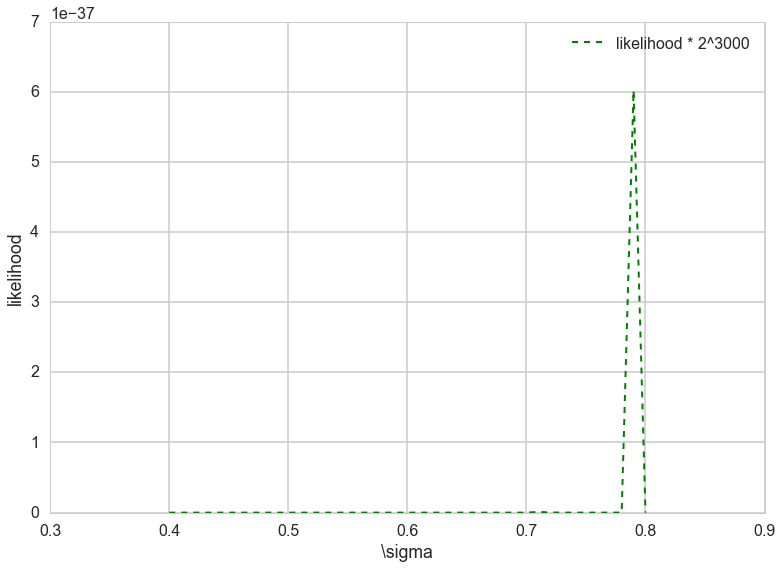

In [60]:
sigma_ls = np.arange(0.6-0.2, 0.6+0.2,0.01)
plt.plot(sigma_ls,likelihood, 'g--',linewidth=2.0, label='likelihood * 2^3000')
plt.ylabel('likelihood')
plt.xlabel('\sigma')
plt.legend(loc='best')

In [61]:
likelihood

array([  1.43868257e-58,   1.98932074e-61,   8.71343342e-57,
         4.66570769e-65,   5.66272851e-67,   1.06562867e-58,
         4.43012006e-58,   6.20102599e-65,   9.28436594e-62,
         2.80124871e-62,   5.39537766e-61,   3.81527591e-58,
         4.08958710e-56,   9.02269111e-56,   2.66090513e-62,
         4.51243350e-54,   6.62266774e-58,   5.18552060e-58,
         4.35956651e-56,   2.08607776e-42,   3.53614200e-50,
         1.85529604e-55,   8.07149128e-58,   8.93669894e-47,
         1.09816096e-50,   4.40052194e-57,   4.85107715e-59,
         4.48475748e-54,   9.92927157e-51,   3.24726392e-51,
         1.11079852e-52,   1.00652737e-39,   1.95633947e-40,
         1.09077262e-49,   3.73794799e-41,   1.55854377e-47,
         3.12047132e-47,   3.10450801e-46,   9.30661520e-46,
         6.01884074e-37,   3.74006321e-45])